<a href="https://colab.research.google.com/github/swaraj0009/AI_Models/blob/master/TFT/notebooks/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA

#### Change the Directory to the directory of this script

In [35]:
# Define base directory for your data files
# BASE_DATA_DIR = "/home/fastStorage/2013-8"  # <-- Update this path as needed
BASE_DATA_DIR = "/content/drive/MyDrive/datasets/fastStorage/2013-8"

#### Import libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from concurrent.futures import ThreadPoolExecutor

import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from pytorch_lightning import Trainer

trainer = Trainer(enable_progress_bar=False, enable_model_summary=False)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


#### Clean column names & convert timestamps

In [37]:
def read_csv_with_vm(f):
    dfraw = pd.read_csv(f, sep=';', engine='c') # Reads each CSV file with `;` as separator
    dfraw['VM'] = os.path.basename(f).split('.')[0] # Adds a new column called `VM` using the filename
    return dfraw

all_files = glob.glob(os.path.join(BASE_DATA_DIR, "*.csv"))  # Update "data" to your folder path if needed

with ThreadPoolExecutor() as executor:
    results = list(executor.map(read_csv_with_vm, all_files)) # Faster loading of many files

dfraw = pd.concat(results, ignore_index=True) # Concatenate all DataFrames into one

dfraw.columns = dfraw.columns.str.strip().str.replace(';', '', regex=False) # Clean column names: strip spaces + remove semicolons

In [38]:
eda = dfraw.copy()

#### Shape & Head

In [39]:
import pandas as pd

print("\n🔹 DataFrame Shape:", eda.shape)

# Show more columns across screen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)  # Adjust width as needed
eda = eda.rename(columns={'Timestamp [ms]': 'Timestamp [s]'})
# Now print first few rows
print(eda.head())


🔹 DataFrame Shape: (11221800, 12)
   Timestamp [s]  CPU cores  CPU capacity provisioned [MHZ]  CPU usage [MHZ]  CPU usage [%]  Memory capacity provisioned [KB]  Memory usage [KB]  Disk read throughput [KB/s]  Disk write throughput [KB/s]  Network received throughput [KB/s]  Network transmitted throughput [KB/s] VM
0     1376314846          4                     11703.99824     10912.027692      93.233333                        67108864.0       6.129274e+06                     0.133333                  15981.600000                            0.000000                               2.133333  1
1     1376315146          4                     11703.99824     10890.570362      93.050000                        67108864.0       6.755624e+06                     1.333333                  19137.333333                            0.000000                               2.600000  1
2     1376315446          4                     11703.99824     10434.114431      89.150000                        6710

#### Missing Values

In [40]:
print("\n🔹 Missing Value Summary:\n", eda.isnull().sum())

# Display data types
print("\nℹ️ Data Types Info:")
print(eda.dtypes)

print(eda.columns.tolist())


🔹 Missing Value Summary:
 Timestamp [s]                            0
CPU cores                                0
CPU capacity provisioned [MHZ]           0
CPU usage [MHZ]                          0
CPU usage [%]                            0
Memory capacity provisioned [KB]         0
Memory usage [KB]                        0
Disk read throughput [KB/s]              0
Disk write throughput [KB/s]             0
Network received throughput [KB/s]       0
Network transmitted throughput [KB/s]    0
VM                                       0
dtype: int64

ℹ️ Data Types Info:
Timestamp [s]                              int64
CPU cores                                  int64
CPU capacity provisioned [MHZ]           float64
CPU usage [MHZ]                          float64
CPU usage [%]                            float64
Memory capacity provisioned [KB]         float64
Memory usage [KB]                        float64
Disk read throughput [KB/s]              float64
Disk write throughput [KB/s]   

#### Check for Infinity Values in Numeric Columns

In [41]:
numeric_cols = eda.select_dtypes(include=[np.number]) # Select only numeric columns
print("\n⚠️ Infinity Check (inf / -inf):") # Check for infinity values
print(np.isinf(numeric_cols).sum()) # Count infinity values in numeric columns


⚠️ Infinity Check (inf / -inf):
Timestamp [s]                            0
CPU cores                                0
CPU capacity provisioned [MHZ]           0
CPU usage [MHZ]                          0
CPU usage [%]                            0
Memory capacity provisioned [KB]         0
Memory usage [KB]                        0
Disk read throughput [KB/s]              0
Disk write throughput [KB/s]             0
Network received throughput [KB/s]       0
Network transmitted throughput [KB/s]    0
dtype: int64


#### UNIQUE VM IDs

In [42]:
if 'VM' in eda.columns:
    unique_vms = eda['VM'].nunique()
    print(f"\n🔹 Unique VM IDs: {unique_vms}")
    print(f"VM ID counts:\n{eda['VM'].value_counts().head()}")
else:
    print("⚠️ VM column not found.")



🔹 Unique VM IDs: 1250
VM ID counts:
VM
842     23692
844     23691
667     23691
61      23690
1213    23690
Name: count, dtype: int64


In [43]:
# ✅ 2. Convert ms to datetime
eda['Timestamp'] = pd.to_datetime(eda['Timestamp [s]'], unit='s', utc=True)


#### TIME INDEX + TIMESTAMP CHECK

In [44]:
print("\n🔹 Time Range:")
print(eda.index.min(), "→", eda.index.max())
print(f"Data covers from {eda['Timestamp'].min()} to {eda['Timestamp'].max()}")


🔹 Time Range:
0 → 11221799
Data covers from 2013-08-12 13:40:46+00:00 to 2013-09-11 13:39:58+00:00


#### Time gap check (global and per VM)


🔹 Time Gaps Between Samples (sec):
count    1.122180e+07
mean     2.309747e-01
std      6.039365e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.010000e+02
Name: Timestamp, dtype: float64


/tmp/ipython-input-45-1069606250.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


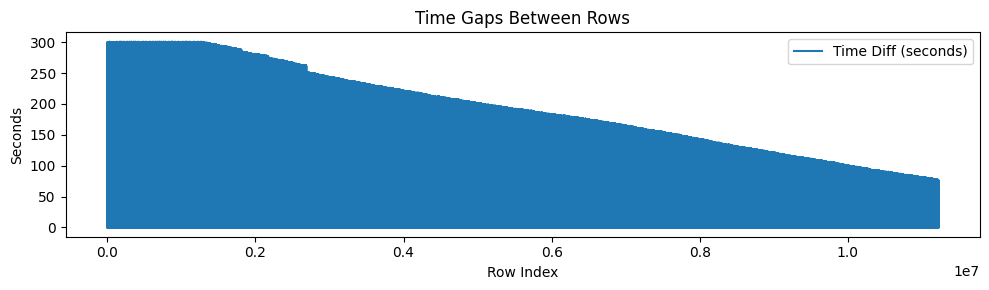

In [45]:
# ✅ 2. Set the index to the new Timestamp column
eda = eda.set_index('Timestamp')

# ✅ 3: Sort to ensure proper time order
eda = eda.sort_index()

# ✅ 4. Calculate time difference between consecutive rows (in seconds)
df_time_diff = eda.index.to_series().diff().dt.total_seconds()

print("\n🔹 Time Gaps Between Samples (sec):")
print(df_time_diff.describe())

# ✅ 5. Plot the time gaps
plt.figure(figsize=(10, 3))
plt.plot(df_time_diff.values, label="Time Diff (seconds)")
plt.title("Time Gaps Between Rows")
plt.ylabel("Seconds")
plt.xlabel("Row Index")
plt.legend()
plt.tight_layout()
plt.show()

#### Distribution plots of metrics (CPU, Memory, etc.) | Use histograms to understand skewness, concentration

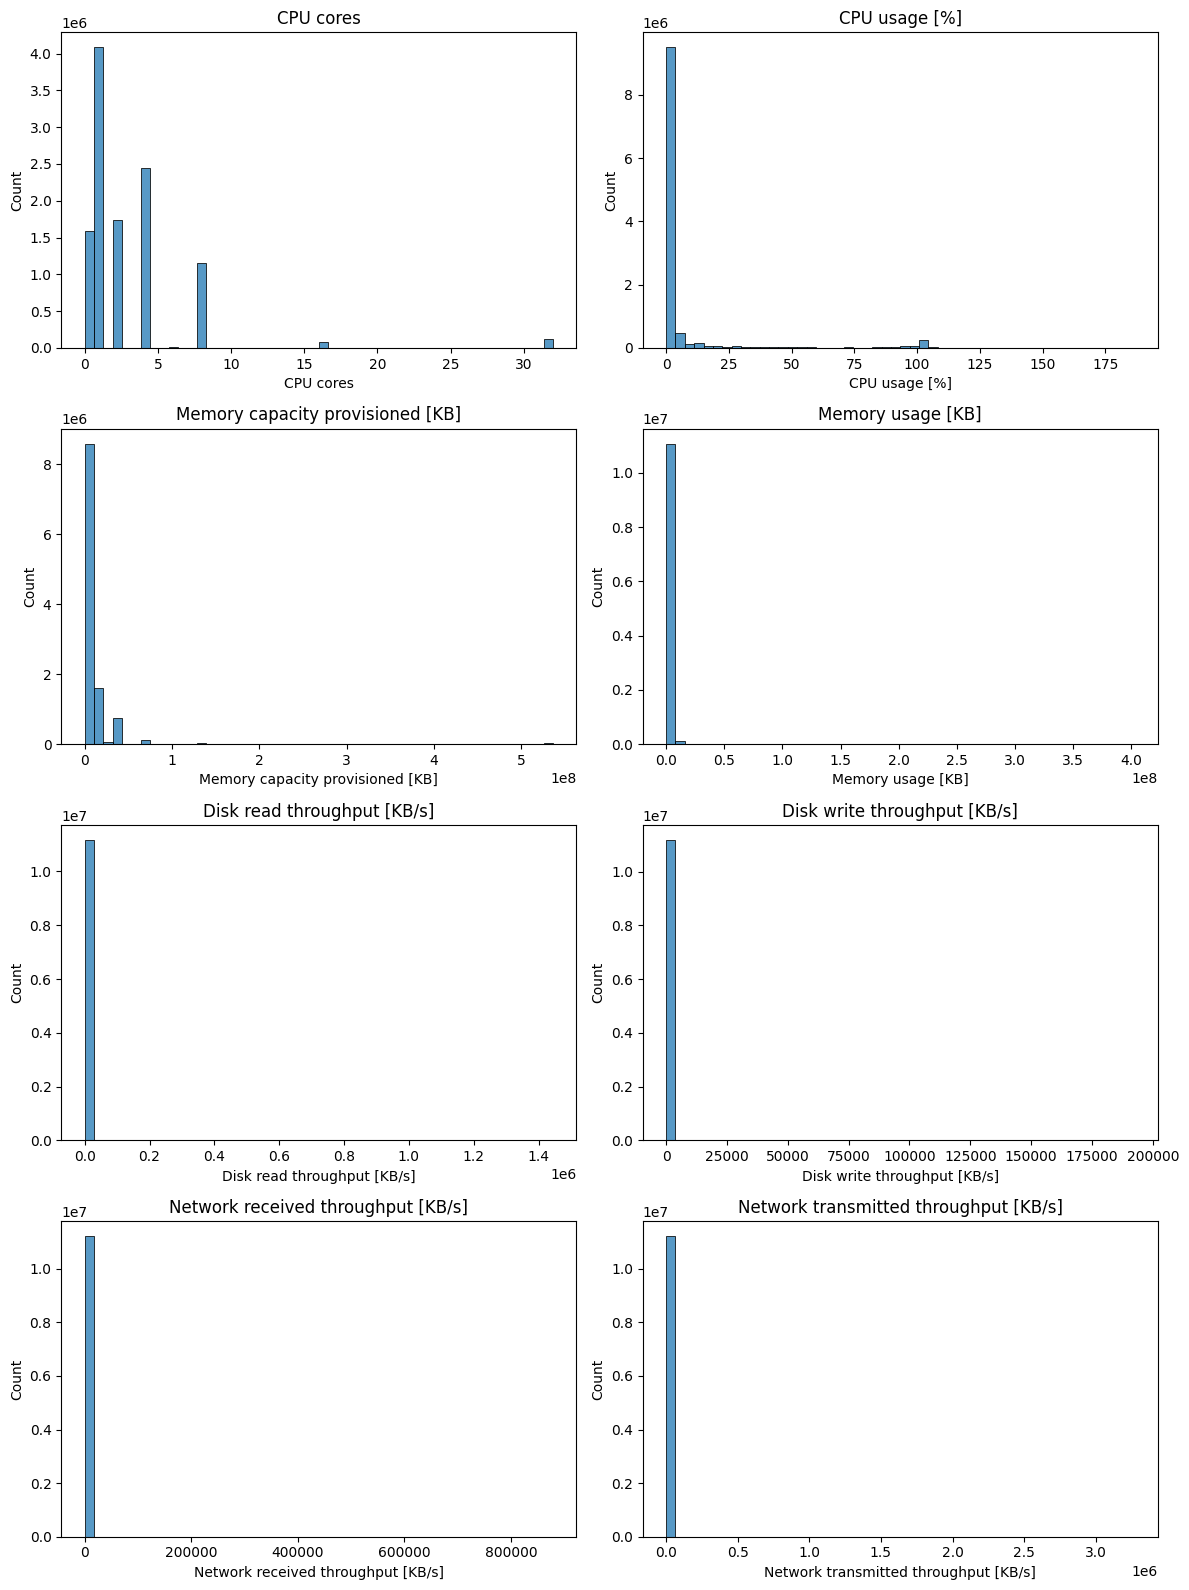

In [46]:
metrics = [
    'CPU cores',
    'CPU usage [%]',
    'Memory capacity provisioned [KB]',
    'Memory usage [KB]',
    'Disk read throughput [KB/s]',
    'Disk write throughput [KB/s]',
    'Network received throughput [KB/s]',
    'Network transmitted throughput [KB/s]'
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))
axes = axes.flatten()

for i, col in enumerate(metrics):
    if col in eda.columns:
        sns.histplot(eda[col], bins=50, ax=axes[i], kde=False, stat="count")
        axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()


#### CORRELATION MATRIX


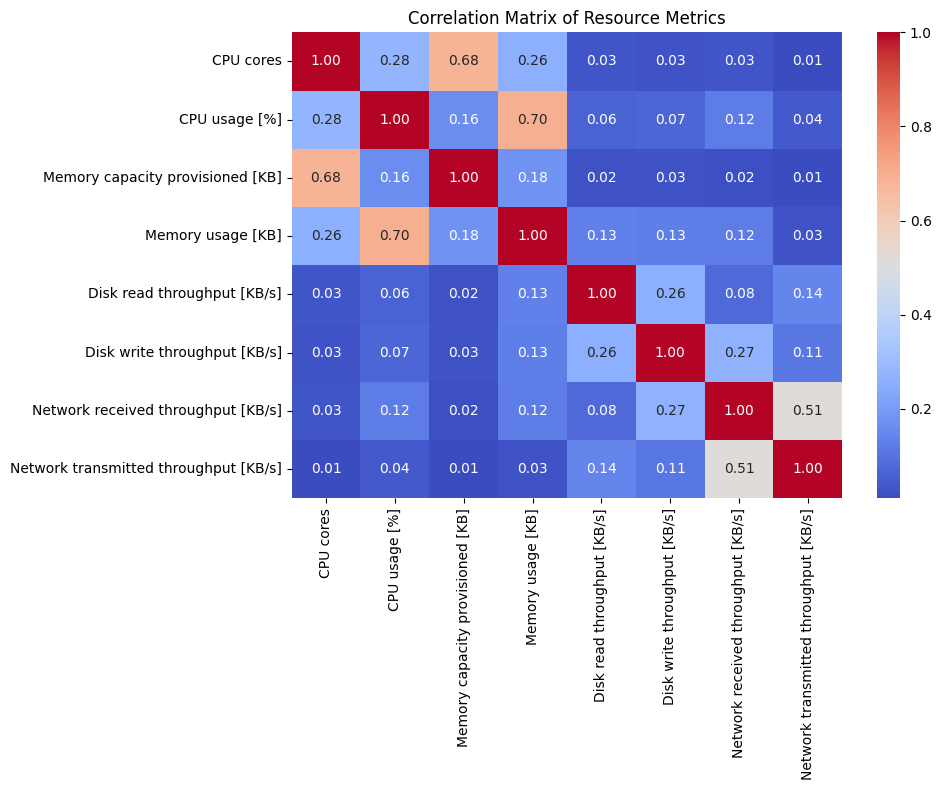

In [47]:
metrics = [
    'CPU cores',
    'CPU usage [%]',
    'Memory capacity provisioned [KB]',
    'Memory usage [KB]',
    'Disk read throughput [KB/s]',
    'Disk write throughput [KB/s]',
    'Network received throughput [KB/s]',
    'Network transmitted throughput [KB/s]'
]

# Drop rows with NaNs in any of the selected metric columns
corr_df = eda[metrics].dropna()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Resource Metrics")
plt.tight_layout()
plt.show()

#### VM-wise usage summary table

          mean        std         max        min  90th_percentile
VM                                                               
970  72.224684  18.066596  108.133333  25.400000        98.266667
245  57.887882  45.050000  106.050000   0.325000       102.908333
591  54.399116   0.409376   54.733333  31.733333        54.500000
247  51.879144  47.945751  104.725000   0.333333       103.825000
249  51.349644  48.265716  105.000000   0.333333       103.916667
656  50.687356   0.413502   52.533333  49.233333        51.233333
257  50.563088  44.936312  106.108333   0.300000       104.125000
243  50.026621  47.863926  104.716667   0.333333       103.258333
221  49.957276  47.589005  105.258333   0.000000       103.941667
255  49.825524  47.137771  105.300000   0.325000       103.466667


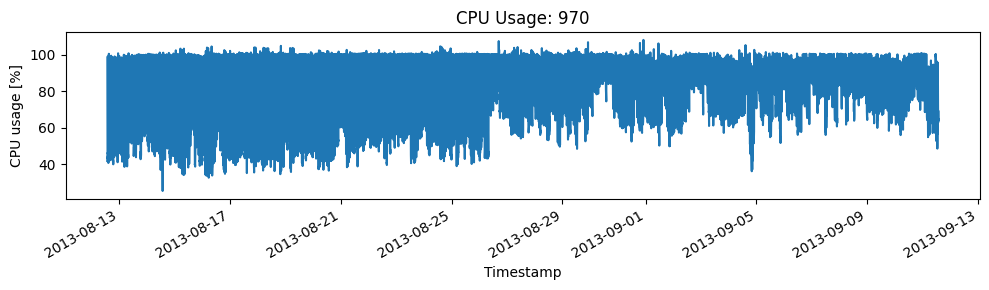

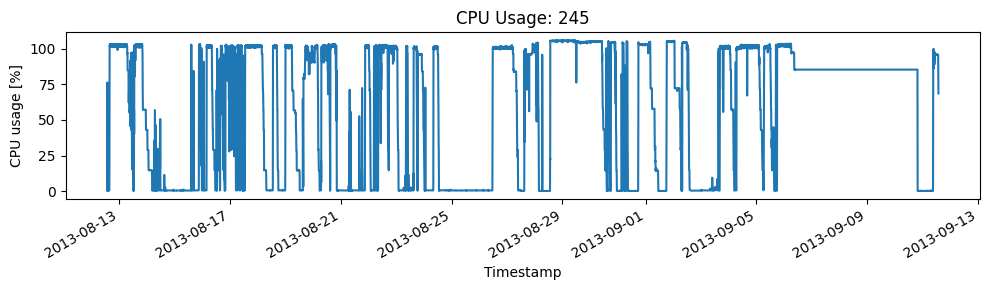

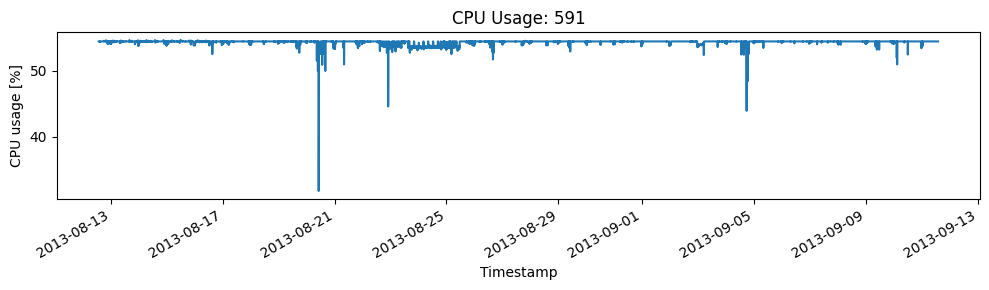

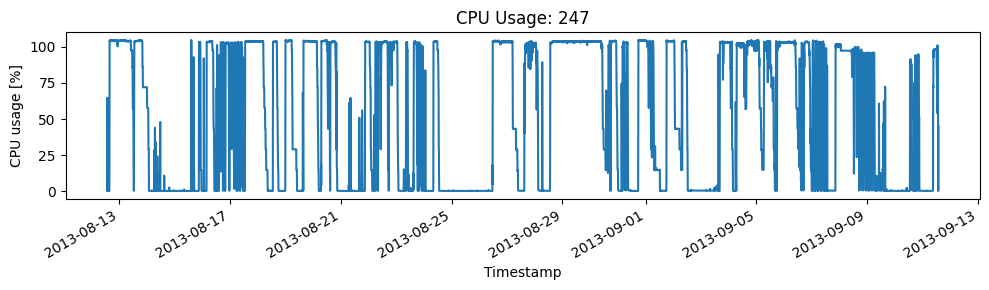

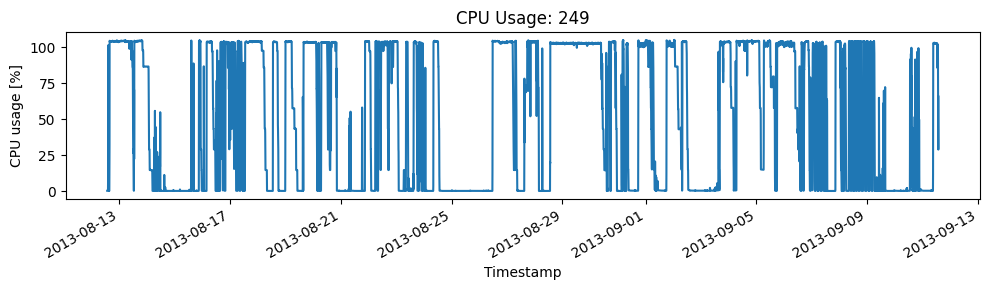

In [48]:
# 1. VM-wise summary
vm_summary = eda.groupby('VM')['CPU usage [%]'].agg(['mean', 'std', 'max', 'min', lambda x: np.percentile(x, 90)]).sort_values(by='mean', ascending=False)
vm_summary = vm_summary.rename(columns={'<lambda_0>': '90th_percentile'})
print(vm_summary.head(10))  # Top 10 high CPU VMs

# 2. Visualize top 5 heavy VMs
top_vms = vm_summary.head(5).index.tolist()
df_top = eda[eda['VM'].isin(top_vms)]

for vm in top_vms:
    df_vm = df_top[df_top['VM'] == vm]
    df_vm['CPU usage [%]'].plot(figsize=(10, 3), title=f"CPU Usage: {vm}")
    plt.ylabel("CPU usage [%]")
    plt.tight_layout()
    plt.show()

# 3. Optional: Save full summary to CSV
# vm_summary.to_csv("results/vm_cpu_summary.csv")

In [49]:
print("Max CPU usage [%]:", eda['CPU usage [%]'].max())

Max CPU usage [%]: 186.6


In [50]:
print(eda.columns)

Index(['Timestamp [s]', 'CPU cores', 'CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]', 'VM'], dtype='object')


#### Save the cleaned DataFrame to a Parquet file

In [51]:
# eda.to_parquet("/home/data/processed/EDA.parquet", index=False)
# eda.to_parquet("/content/drive/MyDrive/datasets/processed/EDAcolab.parquet", index=False)